In [454]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML, display

In [455]:
challenge_output = '../videos/challenge_output.mp4'
challenge = VideoFileClip("../videos/challenge.mp4")

In [456]:
def gray_and_blur(x):
    gray = cv2.cvtColor(x,cv2.COLOR_RGB2GRAY)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blurred_grayed = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    return blurred_grayed

In [457]:
def apply_canny(blurred_grayed):
    return cv2.Canny(blurred_grayed, 105, 105 * 2)

In [458]:
def get_mask(edges, shape):
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    vertices = np.array([[(60,shape[0]),((shape[1]/2)-20, shape[0]/2+60), ((shape[1]/2)+30, shape[0]/2+60), (shape[1]-60,shape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    plt.imshow(edges)
    return cv2.bitwise_and(edges, mask)

In [459]:
def apply_hough(masked_edges, x):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 5
    max_line_gap = 10
    
    # Run Hough on edge detected image
    return cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap) 

In [460]:
def display_region(x):
    ysize = x.shape[0]
    xsize = x.shape[1]
    region_select = np.copy(x)
                   
    left_bottom = [0, ysize - 50]
    right_bottom = [xsize, ysize - 50]
    apex = [xsize/2, (ysize/2)+100]
                   
    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    # Color pixels red which are inside the region of interest
    region_select[region_thresholds] = [255, 0, 0]
    return region_select

In [461]:
def annotate(x):
    blurred_grayed = gray_and_blur(x)
    
    edges = apply_canny(blurred_grayed)
    
    masked_edges = get_mask(edges, x.shape)
    
    lines = apply_hough(masked_edges, x)
    line_image = np.copy(x)*0 #creating a blank to draw lines on

    
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Draw the lines on the edge image
    return cv2.addWeighted(x, 0.8, line_image, 1, 0)

In [462]:
for x in os.listdir("../images/"):
    if x == '.DS_Store':
        continue
    s = "../images/" + x
    #plt.imshow(annotate(mpimg.imread(s)))
    #plt.show()

[MoviePy] >>>> Building video ../videos/challenge_output.mp4
[MoviePy] Writing video ../videos/challenge_output.mp4


 84%|████████▎ | 210/251 [01:52<05:04,  7.43s/it]

OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file ../videos/challenge_output.mp4:

 b''

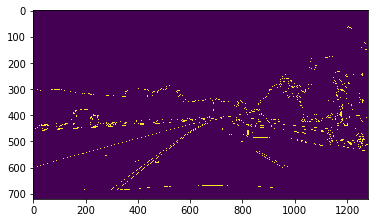

In [463]:
p_challenge = challenge.fl_image(annotate)
%time p_challenge.write_videofile(challenge_output, audio=False)
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(challenge_output))